In [1]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import os
from shutil import copy
import seaborn as sns

from matplotlib import pyplot as plt

import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
# import imageio
from itertools import compress

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#‘xx-small’, ‘x-small’, ‘small’, ‘medium’, ‘large’, ‘x-large’, ‘xx-large’
pylab.rcParams.update(params)
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
# from statsmodels.tsa.api import VAR

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn import tree

import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.optimize import curve_fit
# from tslearn.clustering import KShape, silhouette_score

import gc
import matplotlib.dates as mdates
from sklearn.ensemble import IsolationForest
import math
import warnings
from scipy import stats

In [2]:
def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum

In [3]:
#read data
locus_weights=pd.read_csv('../data/evt_movement_ratio_with_dates.csv')
locus_weights.starttime = pd.to_datetime(locus_weights.starttime,format='%Y-%m-%d')
locus_weights.endtime = pd.to_datetime(locus_weights.endtime,format='%Y-%m-%d')

temperature = pd.read_csv('../data/temperature_for_CAM.csv')
temperature.event_date = pd.to_datetime(temperature.event_date,format='%Y-%m-%d')
temperature.locus_group_id=temperature.locus_group_id.astype('int16')
#not sure in row below as it 'converts' 12.3 -> 12.296875
temperature.value=temperature.value.astype('float16')
temperature['event_year']=temperature['event_date'].dt.year

llg_match= pd.read_csv('../data/locus_locus_group_matching.csv')
llg_match.locus_id=llg_match.locus_id.astype('int32')
llg_match.locus_group_id=llg_match.locus_group_id.astype('int16')

df_dates=pd.read_csv('../data/FW_cycle_dates.csv')
for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
    df_dates[d] = pd.to_datetime(df_dates[d],format='%Y-%m-%d')
    
sfm = pd.read_csv('../data/seawater_freshwater_matching.csv')
sfm_ = sfm[sfm.origin_site_type=='Freshwater'][['target_seawater_locus_id','transport_date','ponding_date','pretransfer_fw_locus_population_id','fish_count_shipped_out','avg_weight_g_stocked']]
sfm_.pretransfer_fw_locus_population_id=sfm_.pretransfer_fw_locus_population_id.astype('int64')

df_target=pd.read_csv('../data/tmp_target.csv')
df_target['transfer_date'] = pd.to_datetime(df_target['transfer_date'],format='%Y-%m-%d')
df_target['transport_year']=df_target['transfer_date'].dt.year

lw_alldates_final = pd.read_csv('../data/lw_alldates_final_locus.csv')
# FIX:
lw_alldates_final.event_date = pd.to_datetime(lw_alldates_final.event_date)

In [4]:
lw_dates=locus_weights.groupby('final_locus_population_id').agg({'starttime':'min','endtime':'max'})
lw_dates.starttime = pd.to_datetime(lw_dates.starttime,format='%Y-%m-%d')
lw_dates.endtime = pd.to_datetime(lw_dates.endtime,format='%Y-%m-%d')
#to be checked
lw_dates['FW_cycle_length'] = (lw_dates.endtime - lw_dates.starttime).dt.days+1
lw_dates['starttime_year']=lw_dates['starttime'].dt.year
#we limit FW cycles to those started in 2017 because there are issues with temperature readings for 2015-2016
lw_dates_2017=lw_dates[lw_dates.starttime_year>=2017]

In [5]:
lw_alldates_final_=lw_alldates_final.merge(llg_match,left_on='historic_locus_id', right_on='locus_id', how='left')
#alternatively rename column before merging. Thus not having to drop column thereafter
lw_alldates_final_.drop(columns='locus_id',inplace=True)

### ph

In [6]:
ph_data = pd.read_csv('../data/indicators_all_file_joined.csv')
ph_data = ph_data[ph_data.sensor_name == 'pH']
ph_data = ph_data.rename(columns={'event_ts': 'event_date', 'sensor_type_value': 'ph_value'})
ph_data.event_date = pd.to_datetime(ph_data.event_date)
# ph_data = ph_data.drop(['sensor_name', 'type_name'], inplace=True)
ph_data.head()

,event_date,locus_group_id,ph_value,sensor_name,type_name
3,2021-12-31,490,7.2,pH,PH
10,2022-01-02,490,7.2,pH,PH
20,2022-01-03,490,7.1,pH,PH
27,2022-01-04,490,7.2,pH,PH
35,2022-01-05,490,7.0,pH,PH


In [7]:
final_locus_weights_ph = lw_alldates_final_.merge(ph_data, how='left')
final_locus_weights_ph['event_year']=final_locus_weights_ph['event_date'].dt.year

final_locus_weights_ph.ph_value=final_locus_weights_ph.ph_value.astype('float32').round(1)
final_locus_weights_ph['weight_ph']=final_locus_weights_ph['weight']*final_locus_weights_ph['ph_value']

final_locus_weights_ph_grouped=final_locus_weights_ph.\
groupby(['final_locus_population_id','event_date'])[['weight_ph']].agg(lambda x: x.sum(skipna=False)).reset_index()
final_locus_weights_ph_grouped.rename(columns={'weight_ph':'ph_value'},inplace=True)

In [8]:
final_locus_weights_ph.ph_value

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
           ... 
32235638    7.0
32235639    NaN
32235640    NaN
32235641    7.1
32235642    7.0
Name: ph_value, Length: 32235643, dtype: float32

In [9]:
# dft=pd.read_csv('../data/lw_alldates_final_grouped.csv')
# dft.event_date = pd.to_datetime(dft.event_date)

#this to interpolate

df_dates_2017=df_dates.merge(
    lw_dates_2017.reset_index()[['final_locus_population_id']],
    left_on='pretransfer_fw_locus_population_id',
    right_on='final_locus_population_id',
    how='inner'
)
df_dates_2017.drop(columns=['final_locus_population_id'], inplace=True)

tmp_list=[]
for ind,row in df_dates_2017.iterrows():
    lp = row.pretransfer_fw_locus_population_id
    start = row.first_movement_date
    end = row.shipout_date
    for d in pd.date_range(start, end):
        tmp_list.append([lp,d])
tmp_df = pd.DataFrame(tmp_list,columns=['final_locus_population_id','event_date'])
dfph_ = tmp_df.merge(final_locus_weights_ph_grouped, how='left')

In [10]:
output_df_ph = pd.DataFrame()
for ind,curr_df in dfph_.groupby('final_locus_population_id'):
    tmp_df=curr_df.copy()
    tmp_df.ph_value=curr_df.ph_value.interpolate()
    output_df_ph=pd.concat([output_df_ph,tmp_df])
dft_filled_ph = output_df_ph.copy()

In [11]:
dft_filled_ph

,final_locus_population_id,event_date,ph_value
0,36783130,2017-01-04,NaN
1,36783130,2017-01-05,NaN
2,36783130,2017-01-06,NaN
3,36783130,2017-01-07,NaN
4,36783130,2017-01-08,NaN
...,...,...,...
1484517,194650523,2023-02-25,7.033333
1484518,194650523,2023-02-26,7.066667
1484519,194650523,2023-02-27,7.100000
1484520,194650523,2023-02-28,7.000000


In [12]:
dft_filled_ph[dft_filled_ph.final_locus_population_id == 36791263].ph_value.isna().sum()

490

In [13]:
full_cycles = [
    194527129, 
    194497496,
    193247058,
    194516980,
    194546436,
    38193840,
    194352023,
    194503079,
    193343886,
    194530157,
    194497483,
    194503096,
    194522881,
    193249474,
    193247433,
    194523185,
    194512165
]

### Non-smoothed

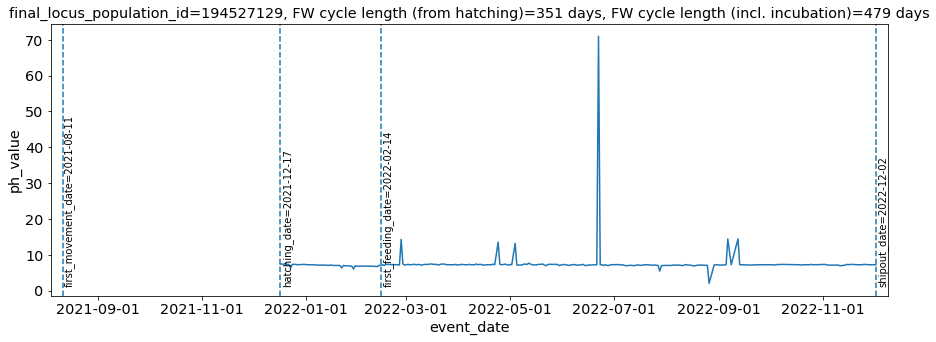

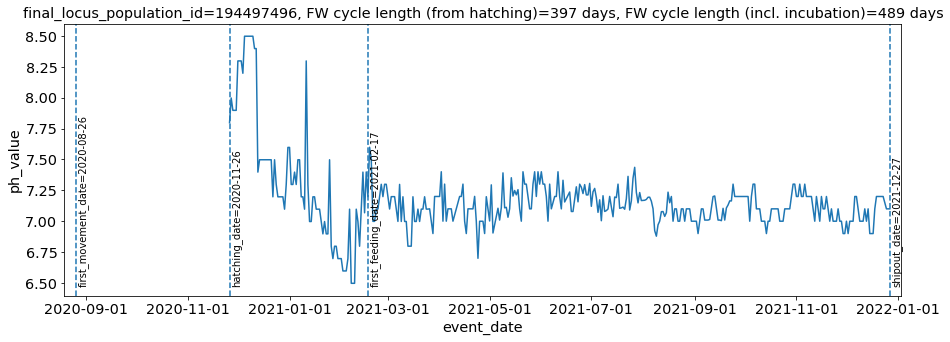

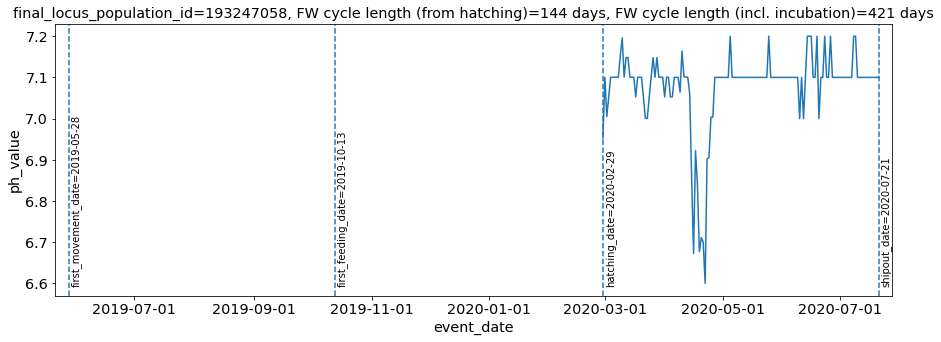

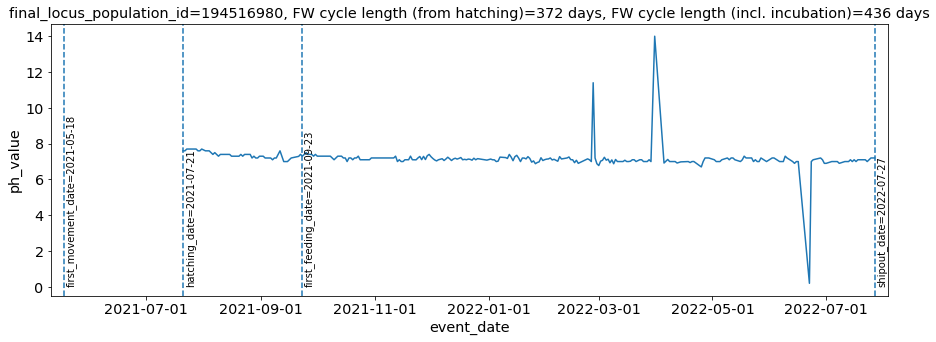

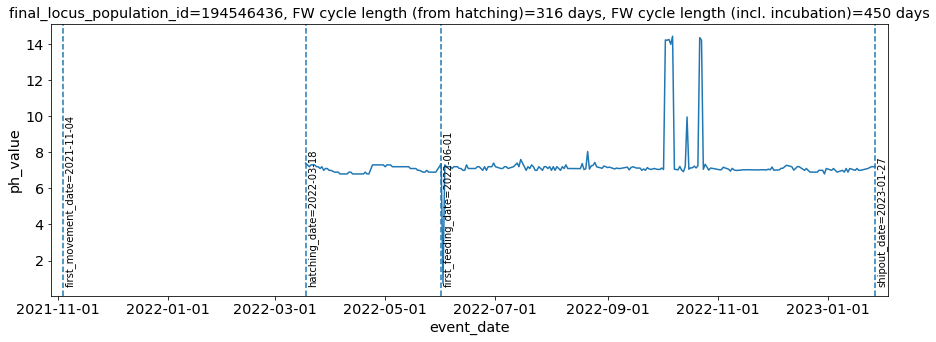

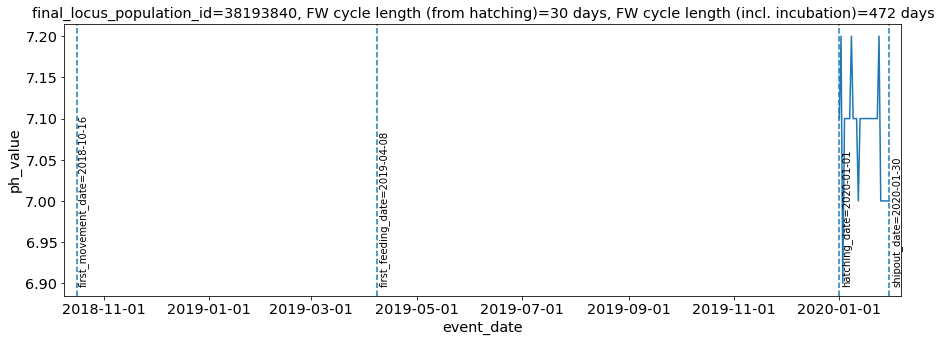

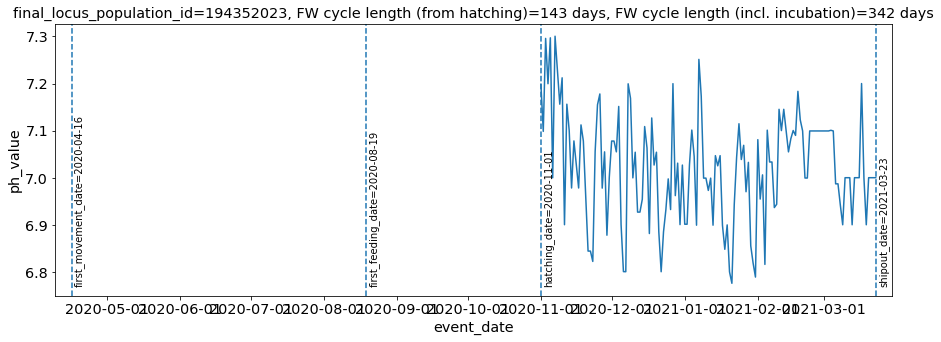

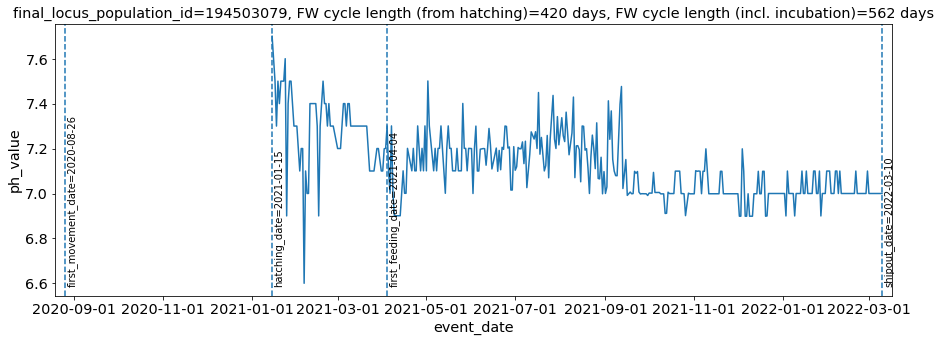

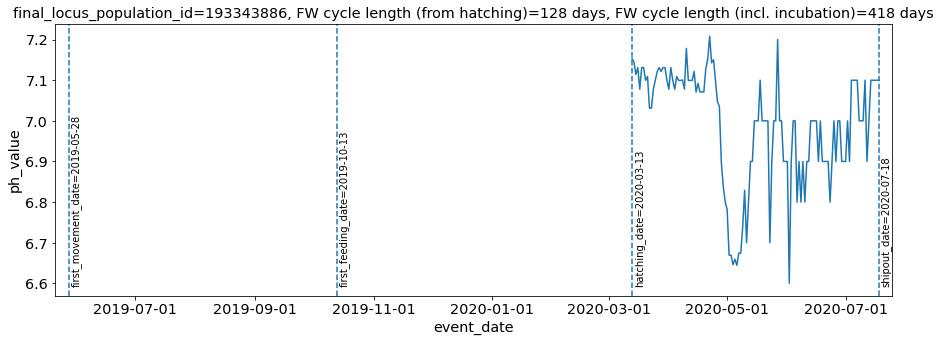

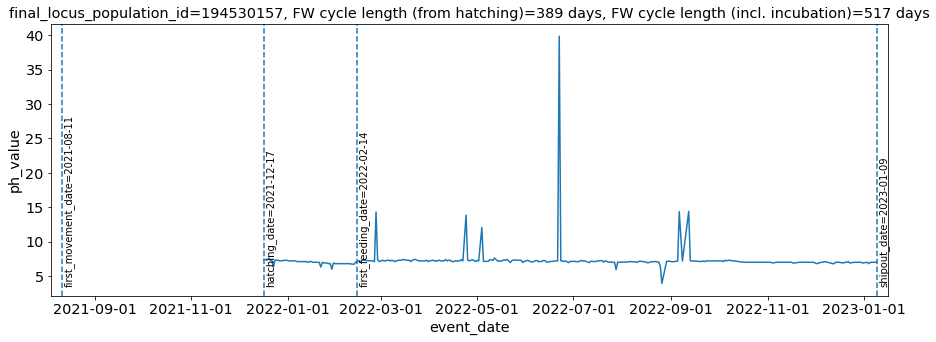

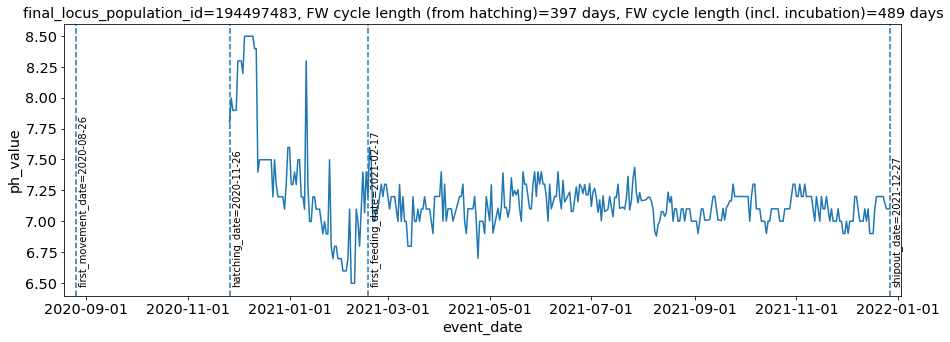

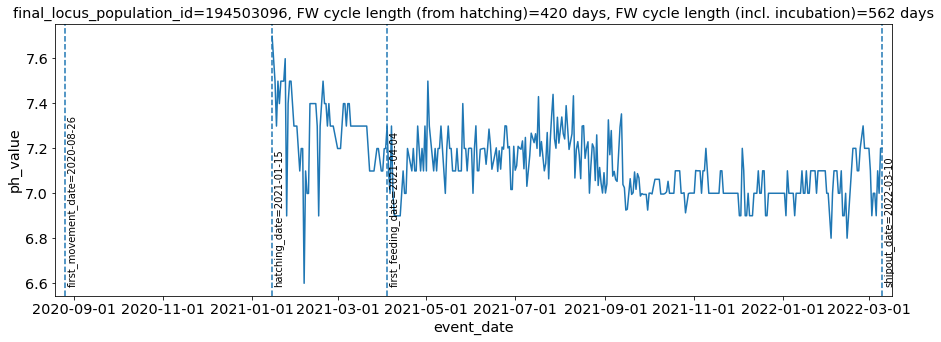

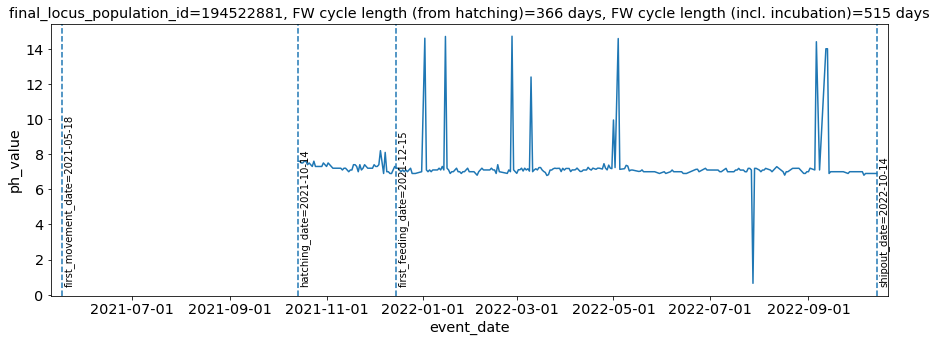

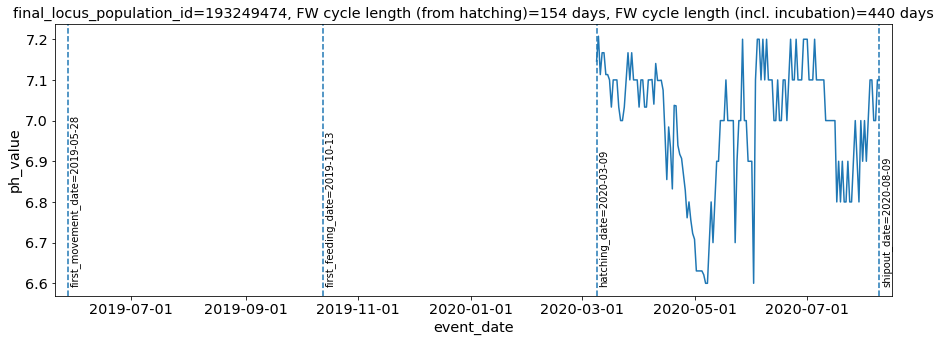

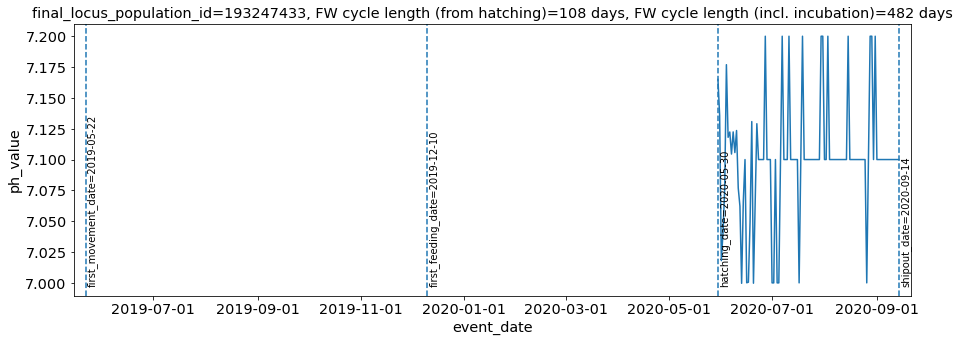

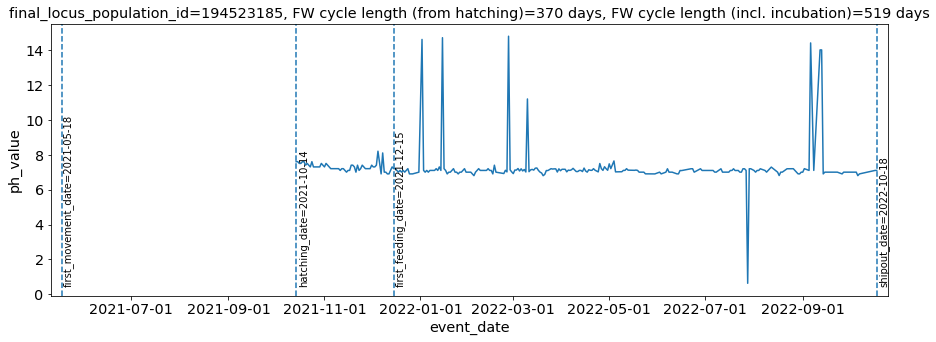

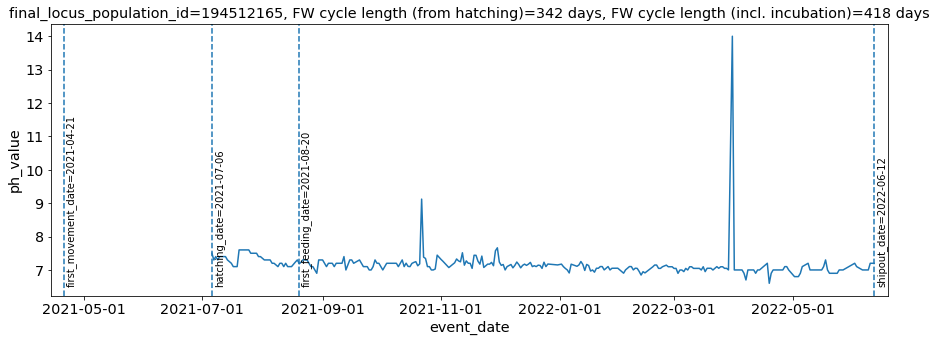

In [14]:
#plot temperature time series charts
j=0
for lp in full_cycles:
    filtered_df = dft_filled_ph[dft_filled_ph.final_locus_population_id==lp]
    if filtered_df.ph_value.isna().sum() != filtered_df.ph_value.shape[0]:
        j+=1
        if (j%100==0): print(j)
        fig, axs = plt.subplots(1, 1)
        sns.lineplot(data=filtered_df, x='event_date',y='ph_value')
        chart_title = 'final_locus_population_id='+str(lp)+', FW cycle length (from hatching)='+str(len(filtered_df.dropna()))+' days' +', FW cycle length (incl. incubation)='+str(len(filtered_df))+' days' 
        plt.title(chart_title)
        min_ph = filtered_df.ph_value.min()
        first_movement_date = filtered_df.event_date.min()
        #not exact definition of hatching date - figure out with James
        hatching_date = filtered_df.dropna().event_date.min()
        shipout_date = filtered_df.event_date.max()
        first_feeding_date=df_dates[df_dates.pretransfer_fw_locus_population_id==lp].first_feeding_date.iloc[0]
        plt.xlim(first_movement_date-datetime.timedelta(days=7),shipout_date+datetime.timedelta(days=7))
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        if (hatching_date-first_movement_date).days<7:
            dates_dict = {
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        else:
            dates_dict = {'first_movement_date': first_movement_date,
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        for i, (name, date) in enumerate(dates_dict.items()):
            plt.axvline(date, linestyle='--')
            plt.text(date + datetime.timedelta(days=1), min_ph, name+'='+date.strftime("%Y-%m-%d"), rotation=90)
        
        plt.show()
#         plt.savefig('Visualisation\\Temperature\\'+chart_title+'.jpg')
        plt.close()

### Smoothing

In [15]:
def get_mean_last_week(df, x):
    df = df.copy().reset_index()
    idx = df[df.ph_value == x].index[0]
    if idx > 7:
        return df.ph_value.iloc[idx-7:idx].mean(skipna=True)
    else:
        return df.ph_value.iloc[:idx].mean(skipna=True)

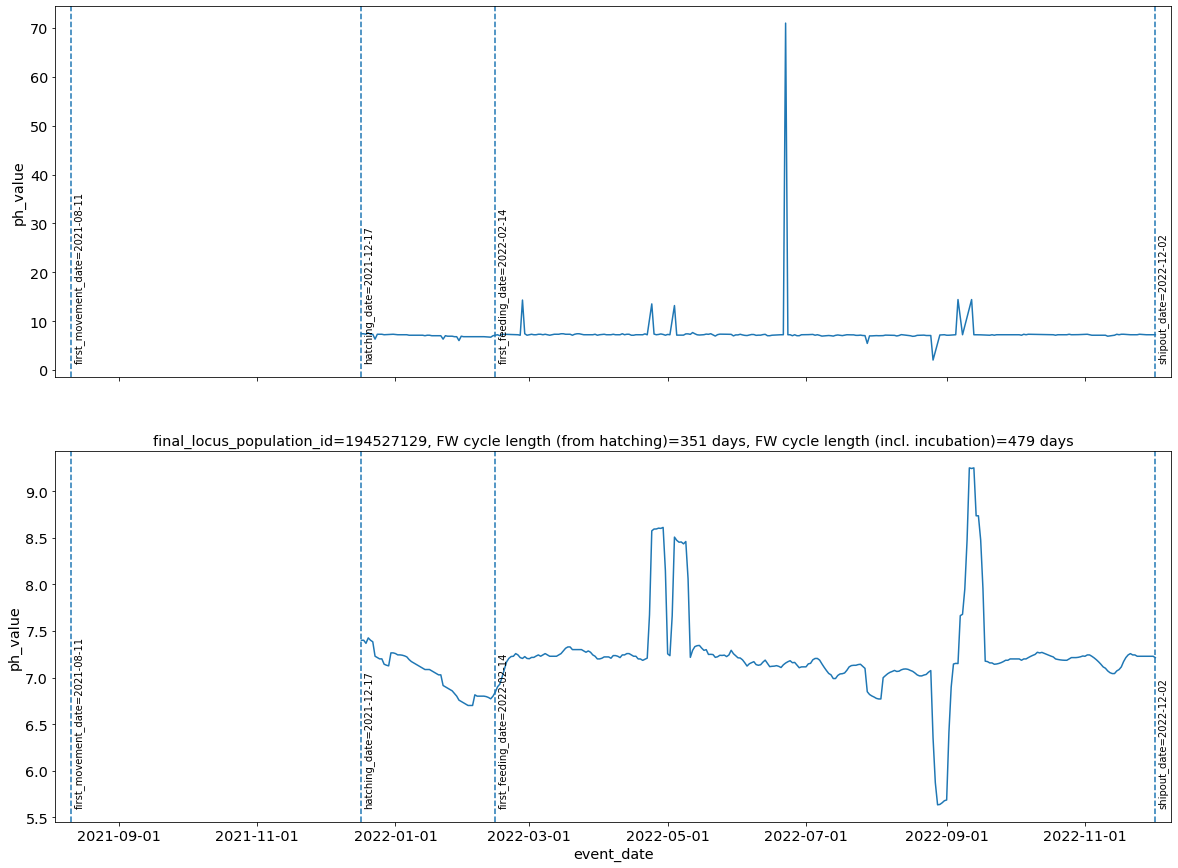

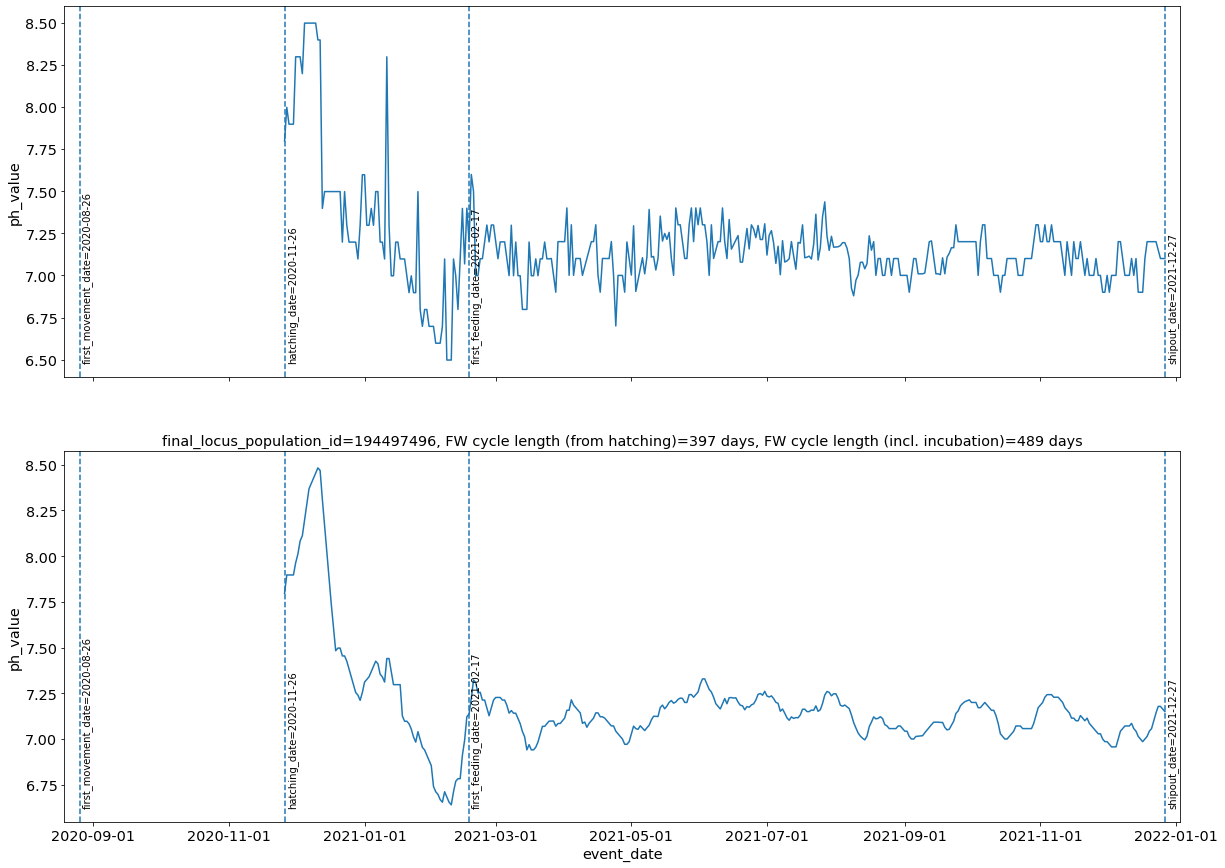

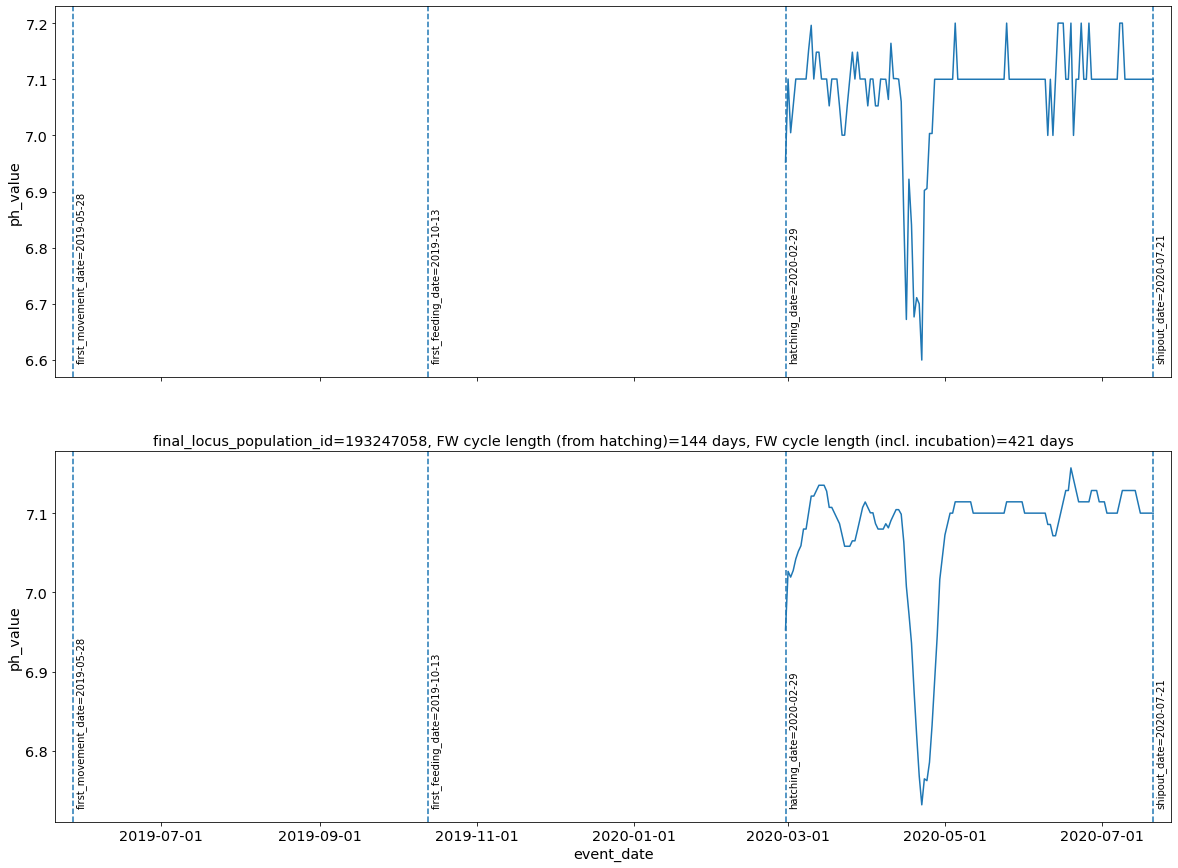

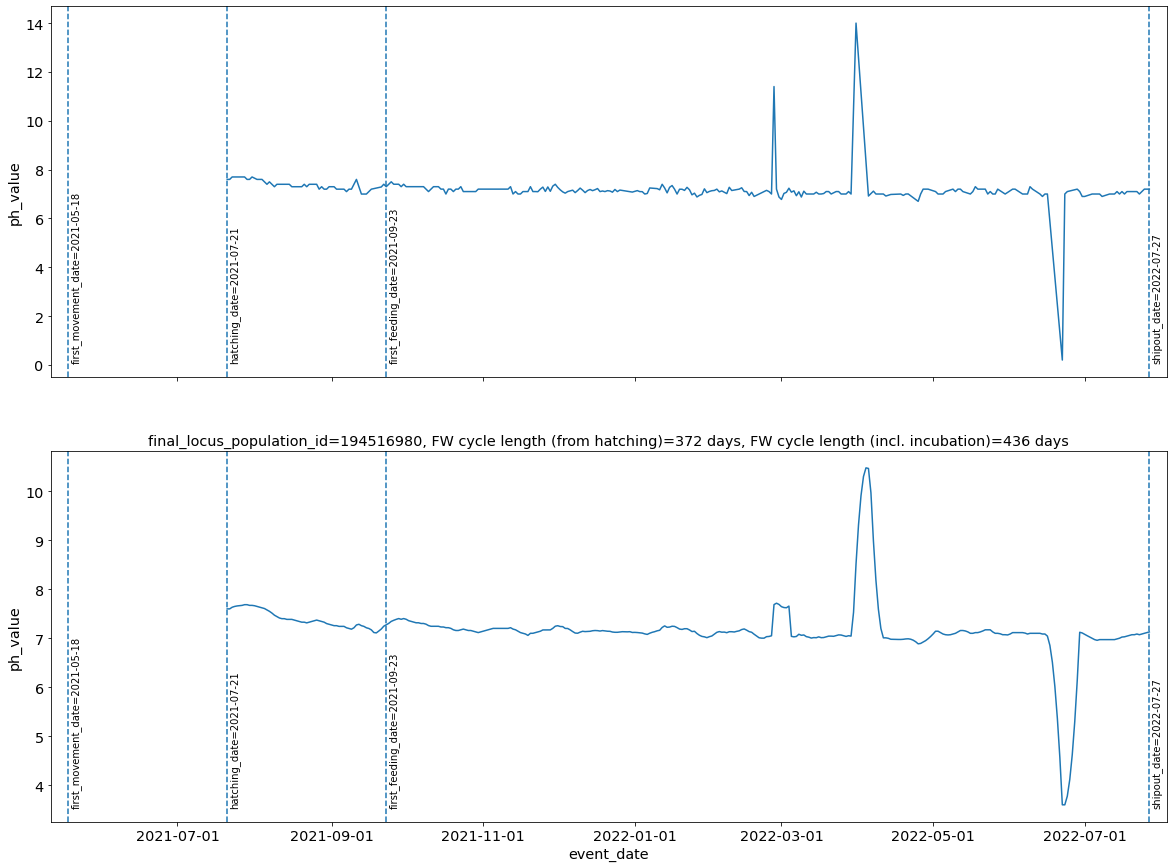

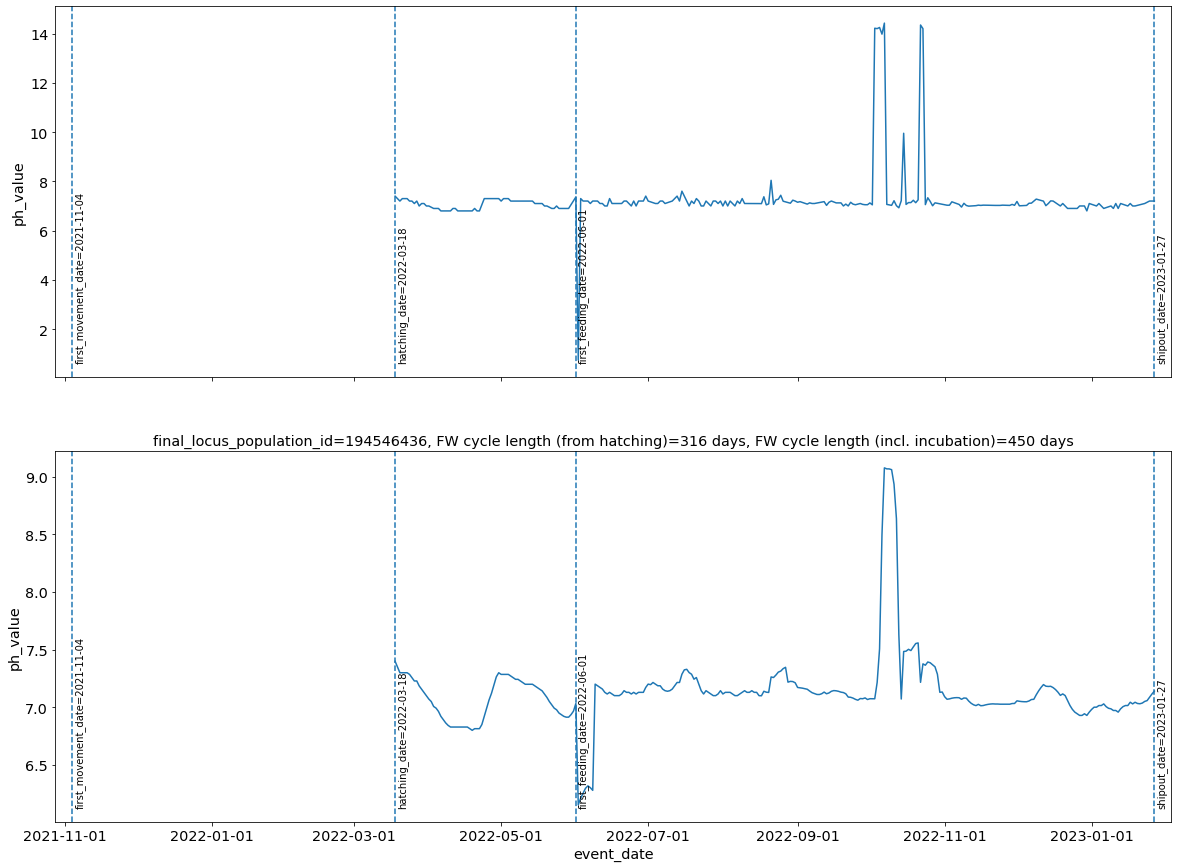

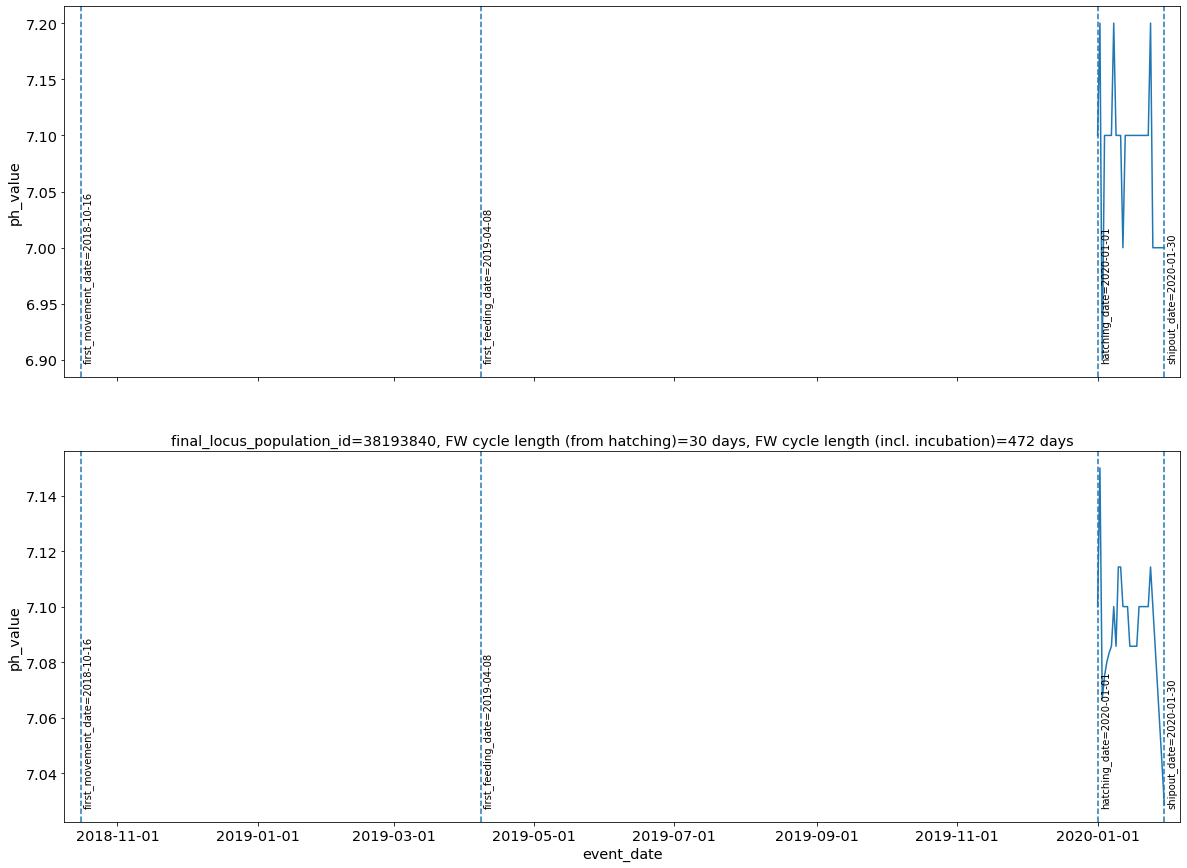

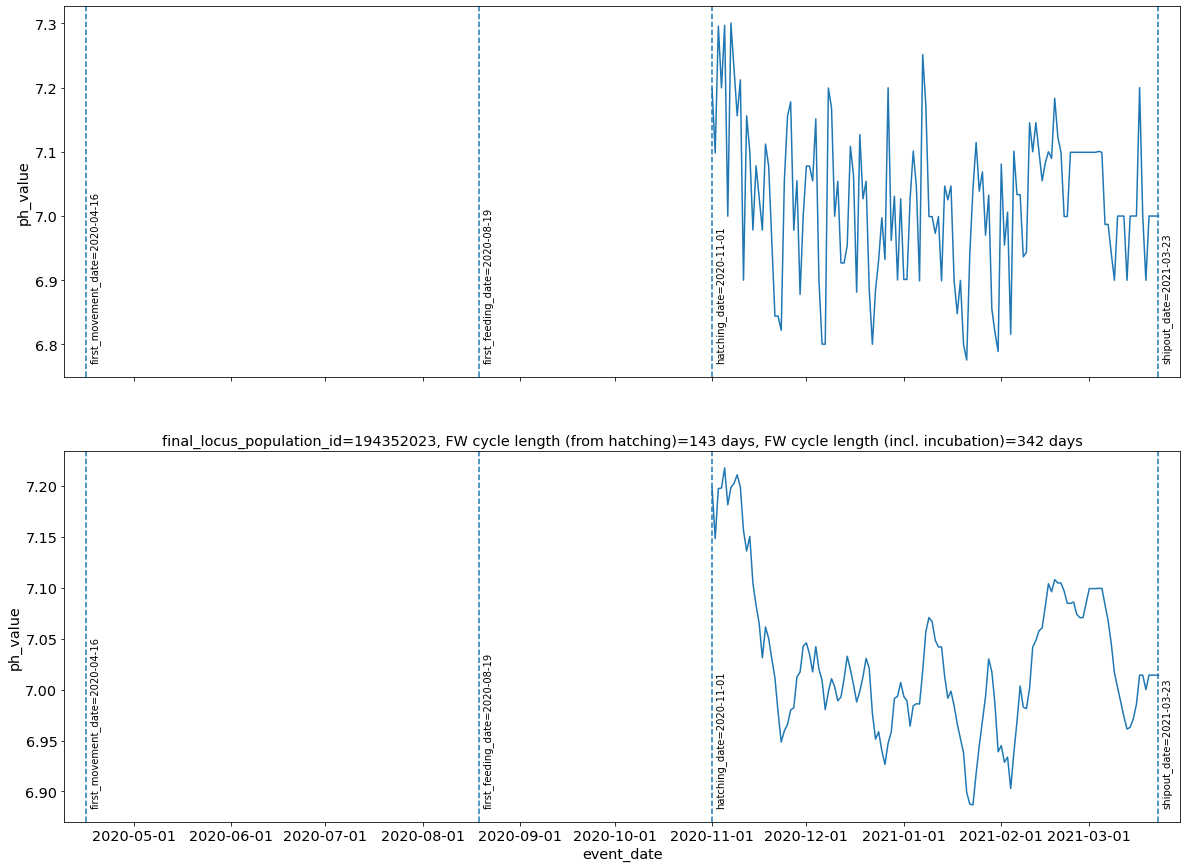

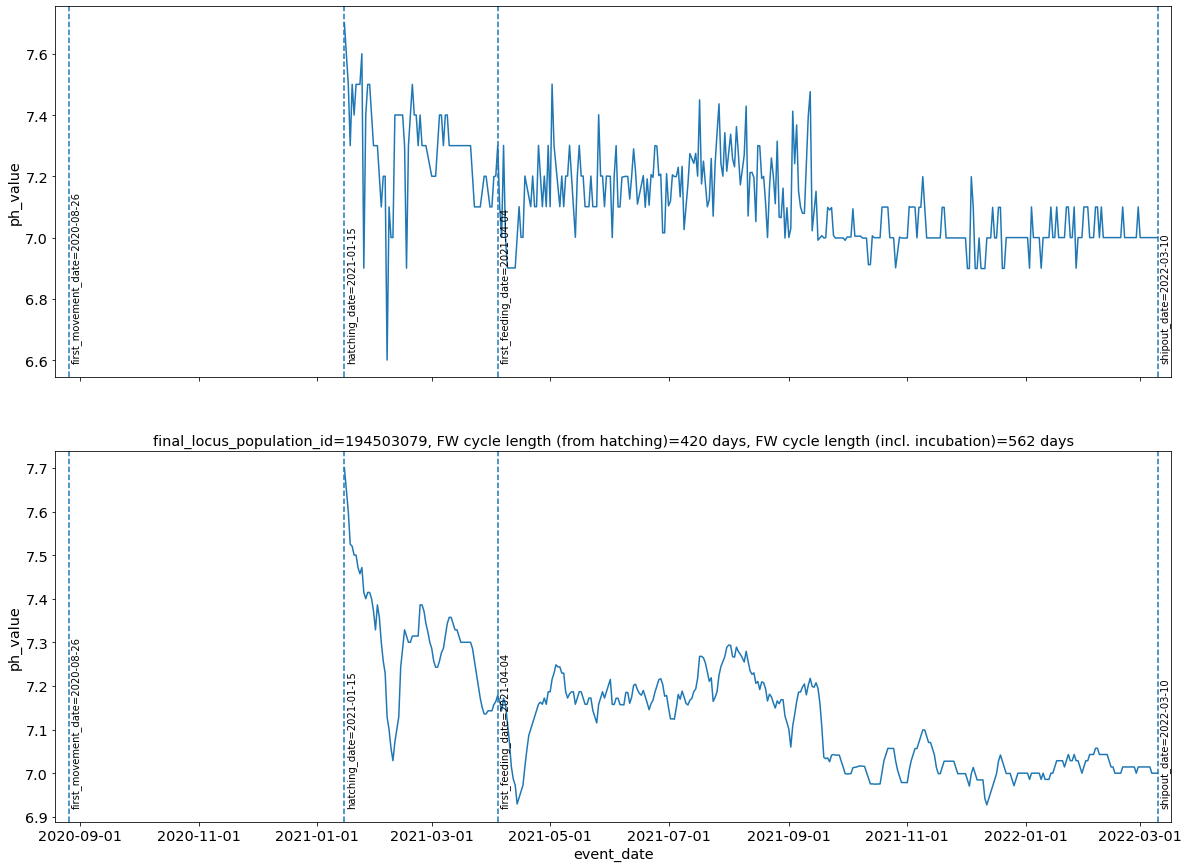

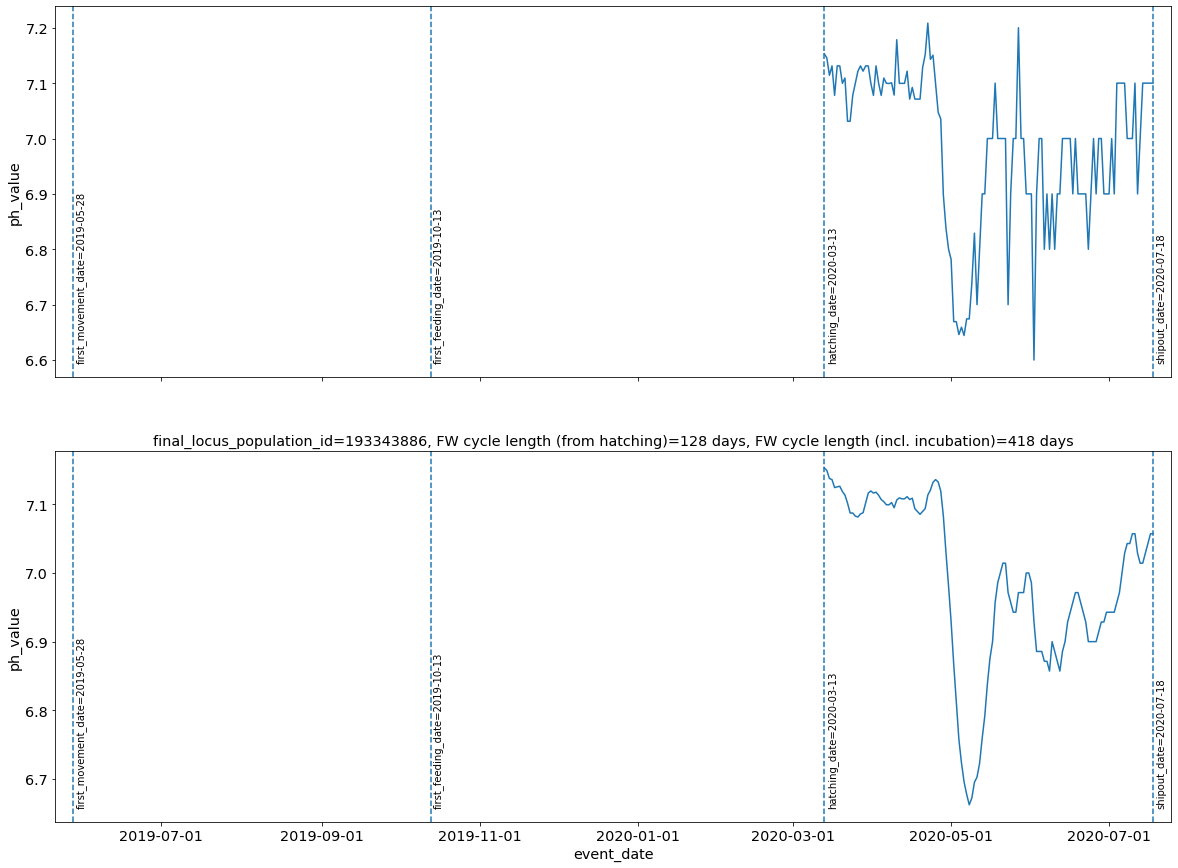

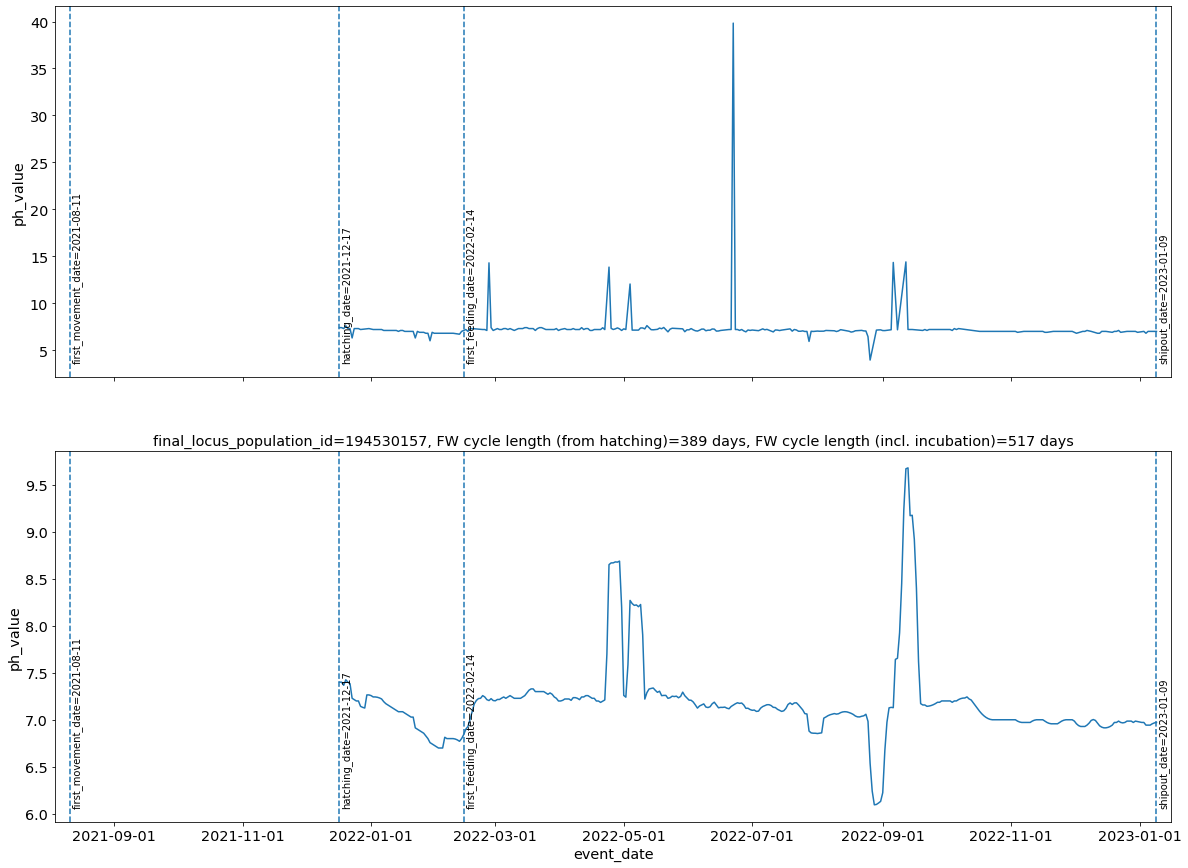

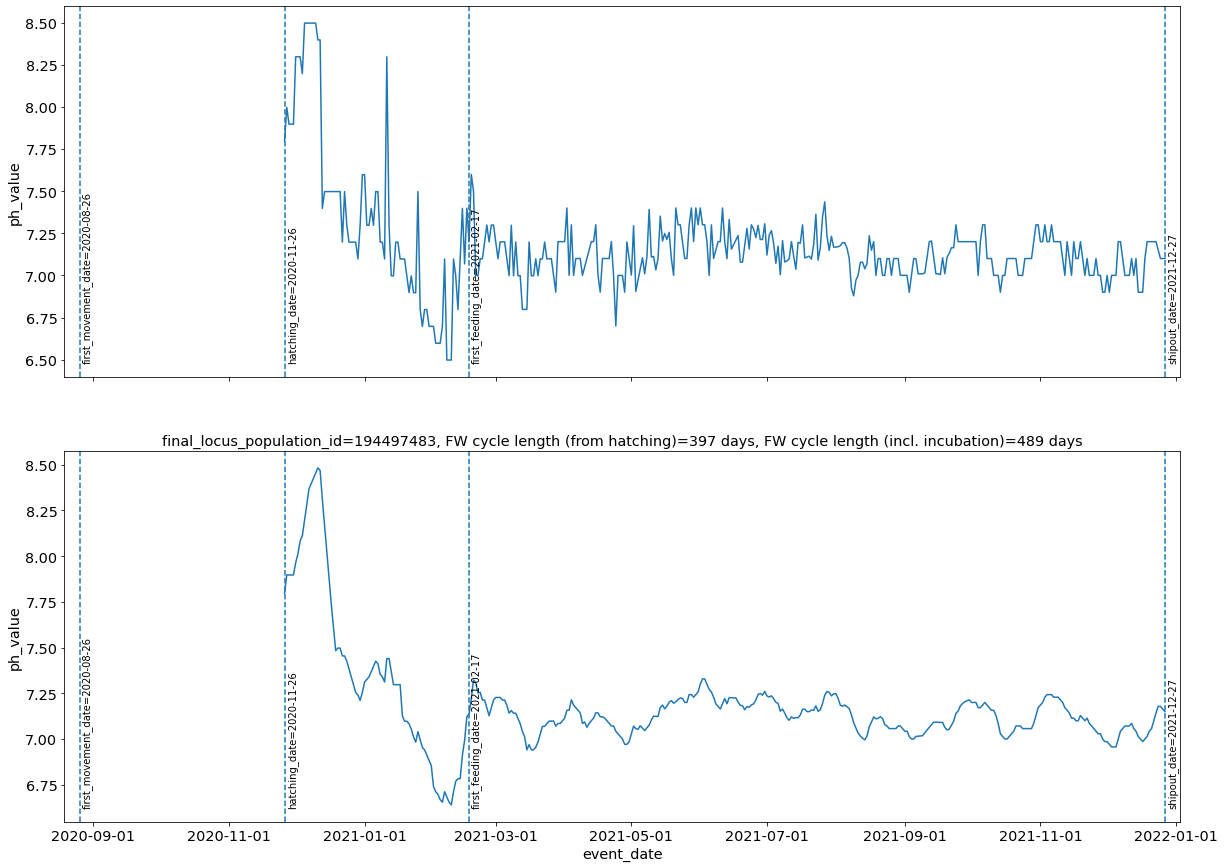

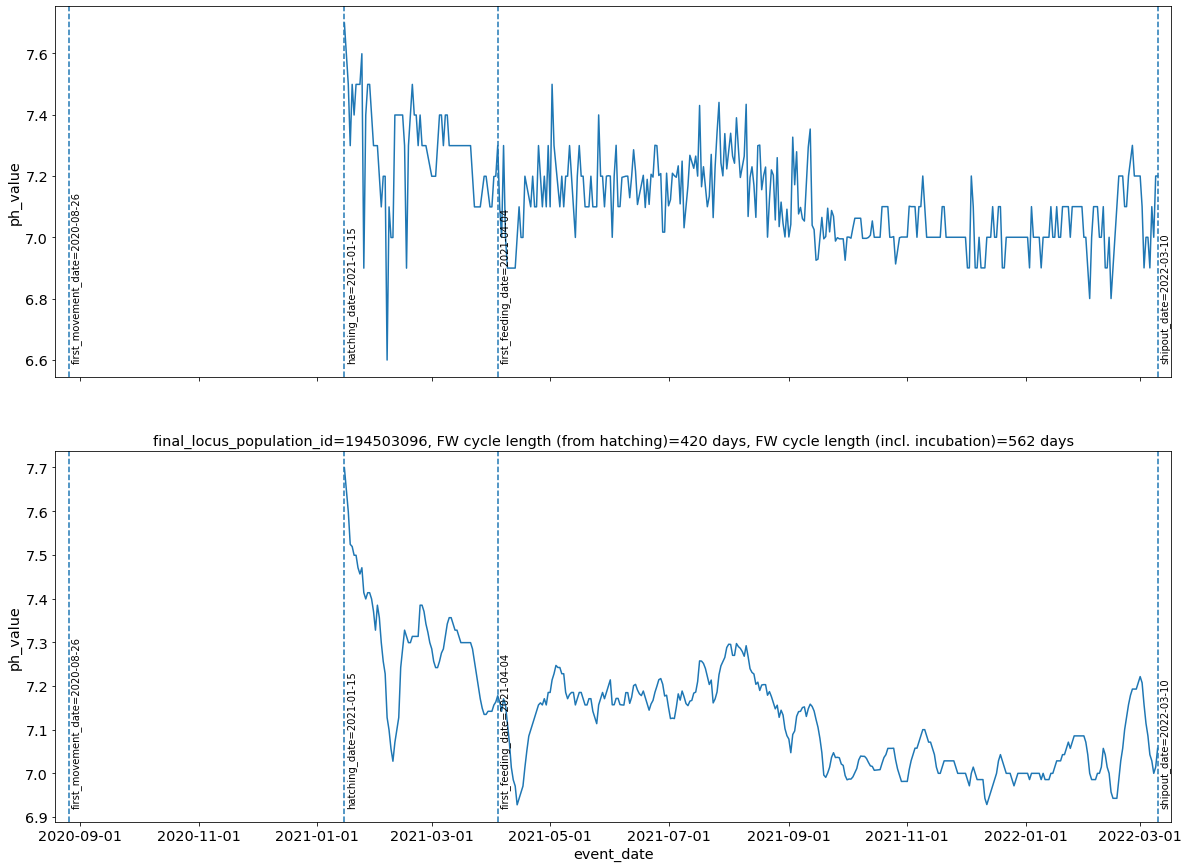

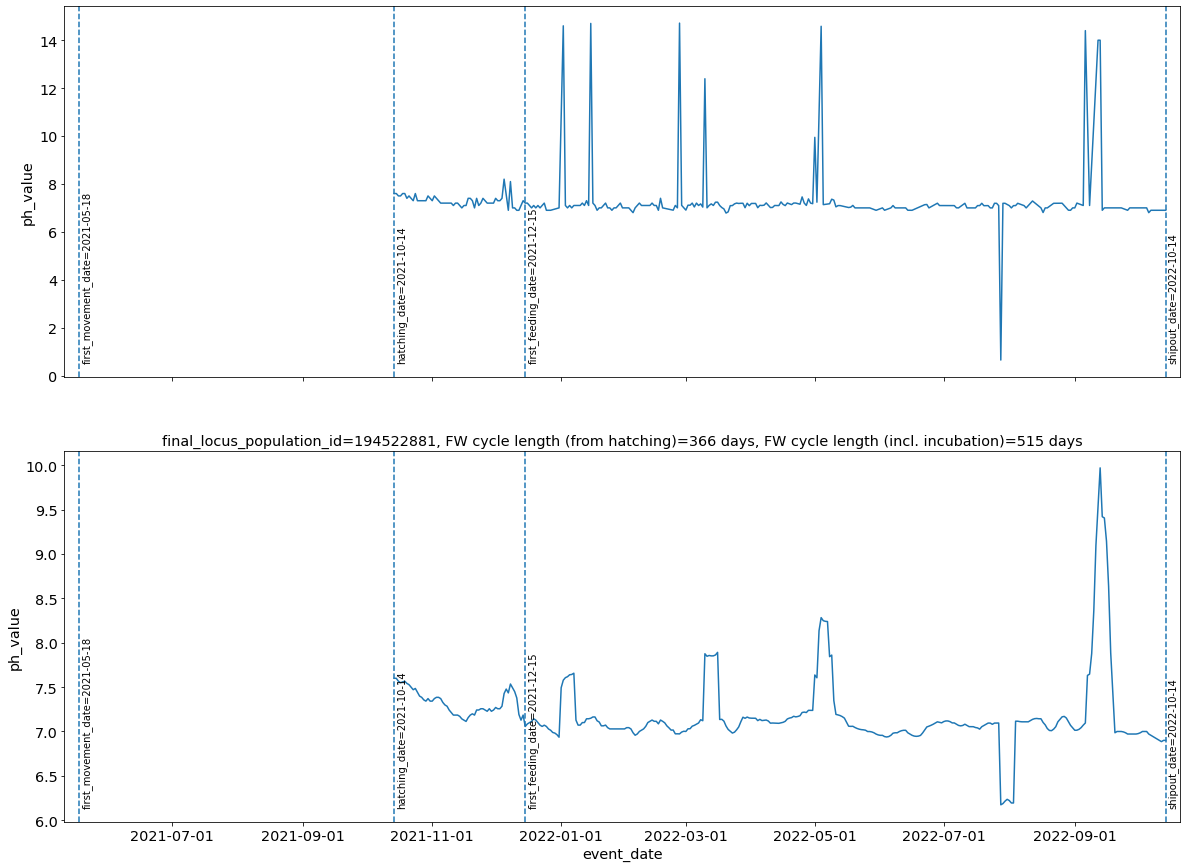

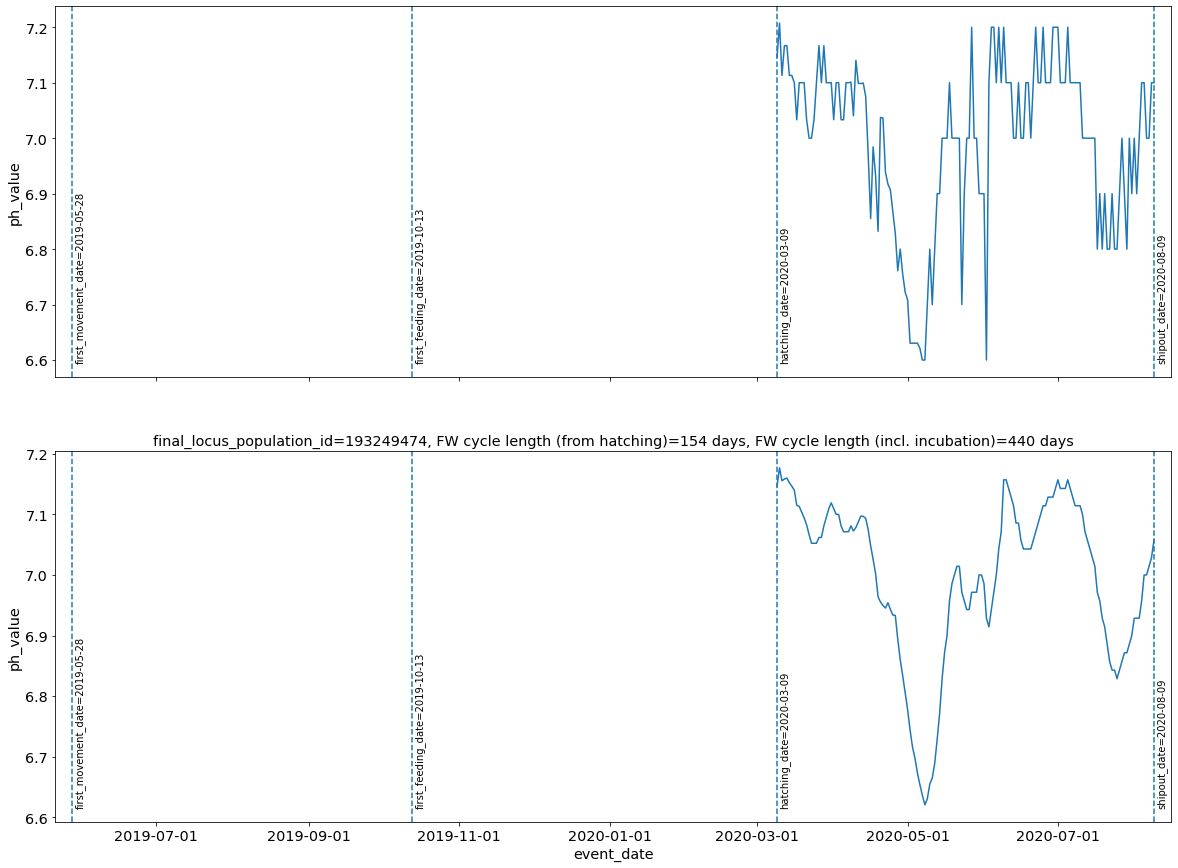

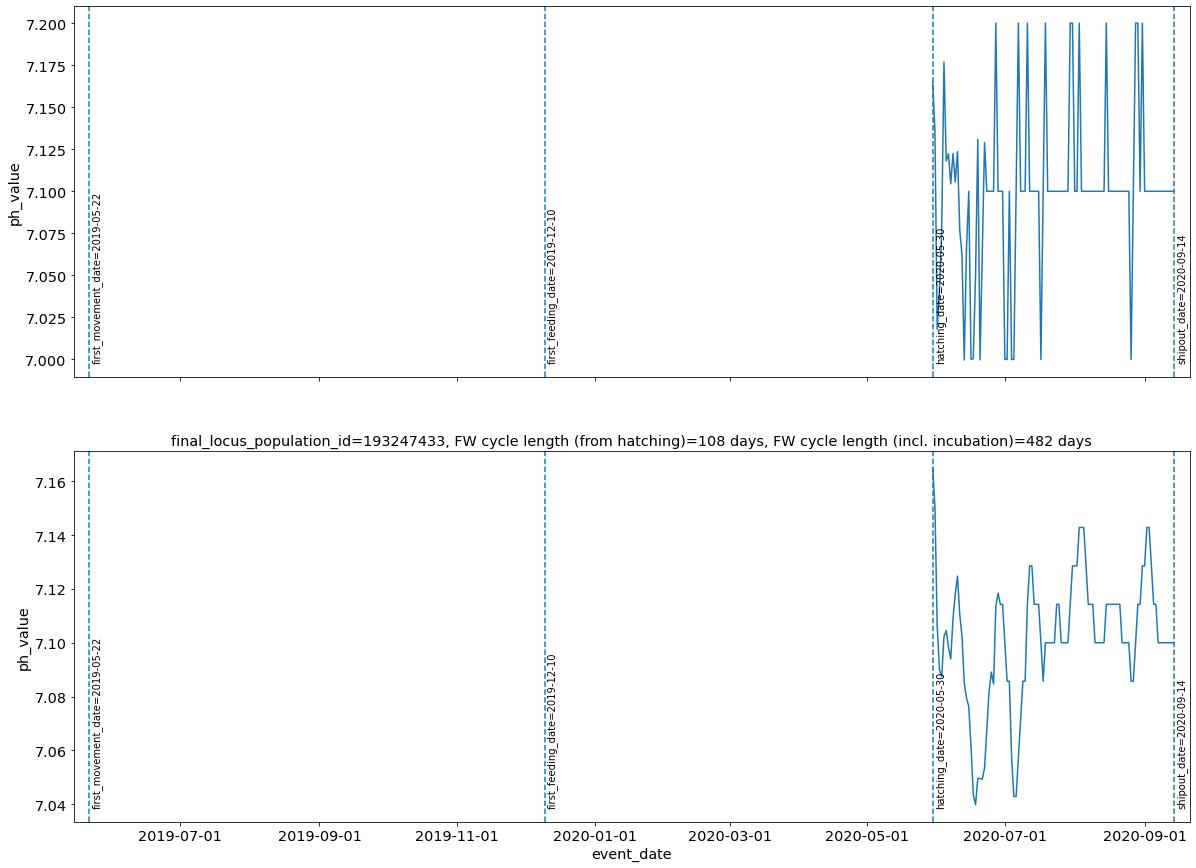

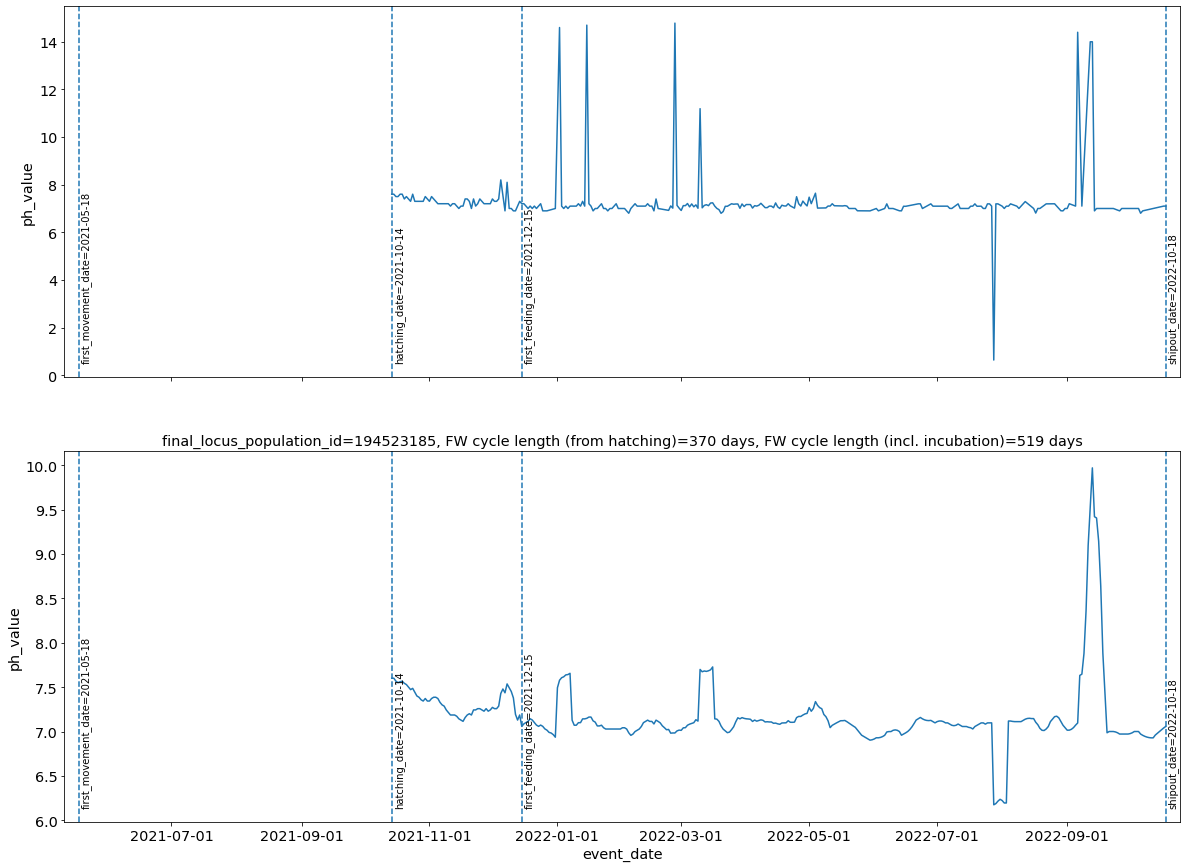

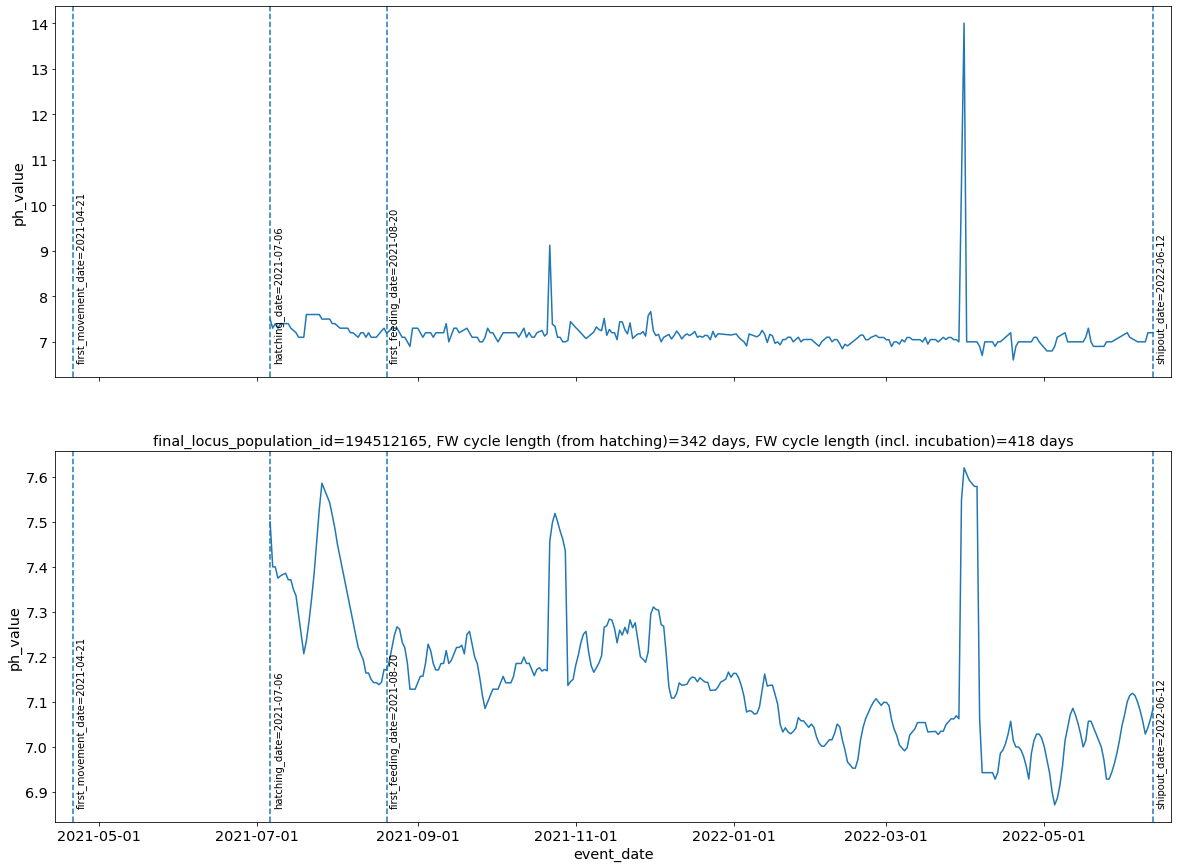

In [16]:
#plot temperature time series charts
j=0
for lp in full_cycles:
# or for all final_locus_population_id 
#for lp in dft_filled_ph.final_locus_population_id.unique():
    filtered_df = dft_filled_ph[dft_filled_ph.final_locus_population_id==lp]
    smoothed_filtered_df = filtered_df.copy()
    
    # replace values > 14 (like 72 instead of 7.2) with the mean of last weak
    smoothed_filtered_df.ph_value = smoothed_filtered_df.ph_value.\
    apply(lambda x: x if (pd.isna(x) or x) < 14 else get_mean_last_week(smoothed_filtered_df, x))
    # weekly rolling window moving averge
    smoothed_filtered_df.ph_value = smoothed_filtered_df.ph_value.rolling(7, min_periods=1).mean()
    if filtered_df.ph_value.isna().sum() != filtered_df.ph_value.shape[0]:  # check if ph data is not np.nan-only
        j+=1
        if (j%100==0): 
            print(j)
        
        fig, axs = plt.subplots(2, 1, figsize=(20, 15), sharex='col')

        sns.lineplot(data=filtered_df, x='event_date',y='ph_value', ax=axs[0])
        sns.lineplot(data=smoothed_filtered_df, x='event_date',y='ph_value', ax=axs[1])

        chart_title = 'final_locus_population_id='+str(lp)+', FW cycle length (from hatching)='+str(len(filtered_df.dropna()))+' days' +', FW cycle length (incl. incubation)='+str(len(filtered_df))+' days' 
        plt.title(chart_title)
        min_ph, smoothed_min_ph, = filtered_df.ph_value.min(), smoothed_filtered_df.ph_value.min()
        first_movement_date = filtered_df.event_date.min()
        #not exact definition of hatching date - figure out with James
        hatching_date = filtered_df.dropna().event_date.min()
        shipout_date = filtered_df.event_date.max()
        first_feeding_date=df_dates[df_dates.pretransfer_fw_locus_population_id==lp].first_feeding_date.iloc[0]
        for ax in axs:
            ax.axis(xmin=first_movement_date-datetime.timedelta(days=7), xmax=shipout_date+datetime.timedelta(days=7))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        if (hatching_date-first_movement_date).days<7:
            dates_dict = {
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        else:
            dates_dict = {'first_movement_date': first_movement_date,
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        for i, (name, date) in enumerate(dates_dict.items()):
            for ax, y_val in zip(axs, (min_ph, smoothed_min_ph)):
                ax.axvline(date,  linestyle='--')
                ax.text(date + datetime.timedelta(days=1), y_val, name+'='+date.strftime("%Y-%m-%d"), rotation=90)
        plt.show()
        fig.savefig(f'./img/ph_vs_time_{chart_title}.png')
        plt.close()